very loosely based on https://keras.io/examples/vision/mnist_convnet/

In [ ]:
outdim=2

In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K

In [ ]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
bx_train = np.expand_dims(x_train, -1)
bx_test = np.expand_dims(x_test, -1)
print("x_train shape:", bx_train.shape)
print(bx_train.shape[0], "train samples")
print(bx_test.shape[0], "test samples")


# convert class vectors to binary class matrices
by_train = keras.utils.to_categorical(y_train, num_classes)
by_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [ ]:
classes=[6,9]
x_train=np.array(
    [xx for xx,yy in zip(bx_train,by_train) if
      np.any([yy[cc] for cc in classes])
    ])
y_train=np.array([yy for yy in by_train if np.any([yy[cc] for cc in classes])])
print(x_train.shape)
print(y_train.shape)

xa_test=np.array(
    [xx for xx,yy in zip(bx_test,by_test) if
      not np.any([yy[cc] for cc in classes])
    ])
ya_test=np.array([yy for yy in by_test if not np.any([yy[cc] for cc in classes])])
print(xa_test.shape)
print(ya_test.shape)
xn_test=np.array(
    [xx for xx,yy in zip(bx_test,by_test) if
      np.any([yy[cc] for cc in classes])
    ])
yn_test=np.array([yy for yy in by_test if np.any([yy[cc] for cc in classes])])
print(xn_test.shape)
print(yn_test.shape)



(11867, 28, 28, 1)
(11867, 10)
(8033, 28, 28, 1)
(8033, 10)
(1967, 28, 28, 1)
(1967, 10)


In [ ]:
def loss(outdim):
    if outdim==1:
        def lss(a,b):
            q=b
            return K.mean((q-1)**2)
        return lss
    def lss(a,b):
        q=b
        pd=[i for i in range(len(q.shape))]
        pd.remove(pd[-1])
        pd.insert(0,len(pd))
        #print(pd)
        q=K.permute_dimensions(q,tuple(pd))
        #exit()

        #print(q.shape)

        adl=None

        for i in range(outdim):
            for j in range(i+1,outdim):
              ac=K.abs(K.mean(((q[i]-1)*(q[j]-1))))
              if adl is None:
                  adl=ac
              else:
                  adl+=ac

        return adl
    return lss

In [ ]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(7, 7), activation="relu",use_bias=False),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(4, 4), activation="relu",use_bias=False),
        layers.Conv2D(16, kernel_size=(4, 4), activation="relu",use_bias=False),
        layers.Conv2D(4, kernel_size=(2, 2), activation="relu",use_bias=False),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(4,kernel_size=(1,1),activation="linear",padding="same",use_bias=False),
        layers.Flatten(),
        layers.Dense(outdim,use_bias=False)
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 22, 22, 32)        1568      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 64)          32768     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 16)          16384     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 4)           256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 4)           0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 2, 4)           1

In [ ]:
batch_size = 128
epochs = 5

model.compile(loss=loss(outdim), optimizer="adam", metrics=[])

model.fit(x_train,
          np.ones_like(x_train),
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.1)

Epoch 1/5
84/84 [==============================] - 12s 131ms/step - loss: 0.0892 - val_loss: 0.0079
Epoch 2/5
84/84 [==============================] - 11s 127ms/step - loss: 0.0203 - val_loss: 0.0067
Epoch 3/5
84/84 [==============================] - 11s 126ms/step - loss: 0.0108 - val_loss: 0.0094
Epoch 4/5
84/84 [==============================] - 11s 127ms/step - loss: 0.0086 - val_loss: 0.0052
Epoch 5/5
84/84 [==============================] - 11s 127ms/step - loss: 0.0072 - val_loss: 0.0164


In [ ]:
pa=model.predict(xa_test)
pn=model.predict(xn_test)

In [ ]:
print(pa.shape)
print(pn.shape)

(8033, 2)
(1967, 2)


In [ ]:
da=np.abs(pa-1)
dn=np.abs(pn-1)
dfa=np.sqrt(np.mean(da**2,axis=1))
dfn=np.sqrt(np.mean(dn**2,axis=1))
print(dfa.shape,dfn.shape)

(8033,) (1967,)


In [ ]:
print("normal",np.mean(dfn),np.std(dfn))
print("abnorm",np.mean(dfa),np.std(dfa))

normal 0.34334755 0.10430497
abnorm 0.3984668 0.11781342


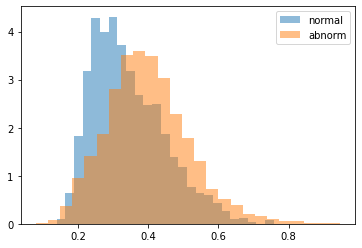

In [ ]:
import matplotlib.pyplot as plt

plt.hist(dfn,bins=25,alpha=0.5,label="normal",density=True)
plt.hist(dfa,bins=25,alpha=0.5,label="abnorm",density=True)
plt.legend()
plt.show()

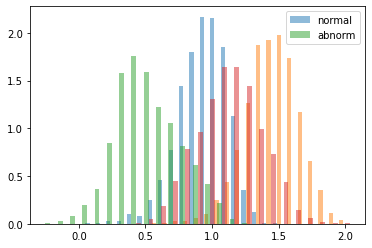

In [ ]:
plt.hist(pn,bins=25,alpha=0.5,label="normal",density=True)
plt.hist(pa,bins=25,alpha=0.5,label="abnorm",density=True)
plt.legend()
plt.show()

In [ ]:
def dexbyloss(lss):return np.argmin(np.mean((pn-lss)**2,axis=1))
minl=np.min(pn,axis=0)
maxl=np.max(pn,axis=0)
print(minl,maxl)
ls=[np.arange(aminl,amaxl,(amaxl-aminl)/9.0001) for aminl,amaxl in zip(minl,maxl)]
print(minl,ls,maxl)
print(len(ls))

[0.04167964 0.5123213 ] [1.4711146 1.9932936]
[0.04167964 0.5123213 ] [array([0.04167964, 0.20050398, 0.35932833, 0.51815268, 0.67697703,
       0.83580138, 0.99462572, 1.15345007, 1.31227442, 1.47109877]), array([0.51232129, 0.67687194, 0.84142259, 1.00597324, 1.17052389,
       1.33507454, 1.49962518, 1.66417583, 1.82872648, 1.99327713])] [1.4711146 1.9932936]
2


In [ ]:
dex=[[dexbyloss([l0,l1]) for l1 in ls[1]] for l0 in ls[0]]
print(dex)

[[582, 582, 681, 681, 223, 223, 223, 223, 223, 784], [395, 582, 392, 174, 223, 223, 223, 223, 784, 784], [728, 1285, 878, 589, 1902, 223, 328, 784, 784, 784], [472, 472, 868, 122, 630, 50, 328, 784, 784, 784], [472, 629, 629, 212, 12, 5, 1526, 784, 784, 1212], [629, 629, 609, 609, 408, 773, 1575, 1196, 1212, 1200], [629, 609, 609, 609, 225, 145, 1170, 1182, 1200, 1558], [609, 609, 609, 225, 225, 666, 564, 688, 1364, 1558], [609, 609, 225, 225, 666, 418, 230, 403, 682, 1677], [609, 225, 225, 225, 230, 230, 230, 1191, 273, 1173]]


In [ ]:
topl=np.array([[xn_test[d] for d in dd] for dd in dex])
print(topl.shape)


(10, 10, 28, 28, 1)


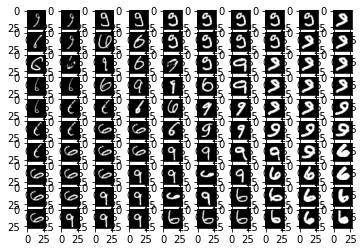

In [ ]:
for i,zx in enumerate(topl):
  for j,zw in enumerate(zx):

    plt.subplot(len(topl),len(zx),1+len(zx)*i+j)
    plt.imshow(zw[:,:,0], cmap=plt.get_cmap('gray'))
plt.show()

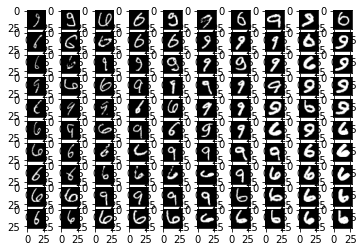

In [ ]:

addon=np.zeros(len(pn),dtype="float")
def dexbyloss(lss):
  dex= np.argmin(np.mean((pn-lss)**2,axis=1)+addon)
  addon[dex]=1000.0
  return dex

ls=[np.arange(aminl,amaxl,(amaxl-aminl)/9.0001) for aminl,amaxl in zip(minl,maxl)]
dex=[[dexbyloss([l0,l1]) for l1 in ls[1]] for l0 in ls[0]]

topl=np.array([[xn_test[d] for d in dd] for dd in dex])

for i,zx in enumerate(topl):
  for j,zw in enumerate(zx):

    plt.subplot(len(topl),len(zx),1+len(zx)*i+j)
    plt.imshow(zw[:,:,0], cmap=plt.get_cmap('gray'))
plt.show()

In [ ]:
td=np.array([[np.argmax(yn_test[d]) for d in dd] for dd in dex])
print(td)

[[9 9 6 6 9 9 6 9 9 6]
 [6 6 6 6 6 9 9 9 6 9]
 [6 6 9 9 9 9 9 9 6 9]
 [9 6 6 9 9 9 9 9 9 9]
 [6 9 9 6 6 9 9 9 6 9]
 [6 9 6 9 6 9 9 6 9 6]
 [6 6 6 6 9 9 9 9 6 6]
 [6 6 6 6 6 6 9 6 6 6]
 [6 6 9 9 9 9 6 6 6 6]
 [6 6 6 6 6 6 6 6 6 6]]


In [ ]:
print(np.mean(td,axis=0),np.mean(np.std(td,axis=0)))
print(np.mean(td,axis=1),np.mean(np.std(td,axis=1)))

[6.6 6.9 6.9 7.2 7.5 8.4 8.1 7.8 6.9 7.2] 1.3808172370956728
[7.8 7.2 8.1 8.4 7.8 7.5 7.2 6.3 7.2 6. ] 1.2323241936836289
